# 5400 Managing Data Project

**Reference**

https://www.alphavantage.co/documentation/#*intelligence*

## Access Data

Import Packages

In [ ]:
# # downloading yahoo finance
# !pip install yfinance

In [1]:
import os
import json
import urllib
import requests
import squarify
import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
from pymongo import MongoClient
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from IPython.display import display
from neo4j import GraphDatabase
from datetime import datetime
from flask import Flask, render_template, request, redirect, url_for
import base64
import io

Helper Function

In [260]:
# create a complete api with ticker, topics, time period, and our key
def getSingleRequest(ticker, topic, time_from, time_to, apikey):
  request  = "https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=" + ticker +  "&topics=" + topic + "&time_from=" + time_from + "&time_to=" + time_to + "&limit=1000" + "&apikey=" + apikey
  return request

#  get the data from the api
def getData(request):
  r = requests.get(request)
  data = r.json()
  return data

# get the top 500 S&P stock name
def get_sp500_list():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]["Symbol"].tolist()
    return sp500_table

In [261]:
# 500 list
ticker = get_sp500_list()

# get top 50 list
stocks_info = []
for symbol in ticker:
    stock = yf.Ticker(symbol)
    info = stock.info
    market_cap = info.get('marketCap', 0)
    stocks_info.append((symbol, market_cap))

df = pd.DataFrame(stocks_info, columns=['Symbol', 'MarketCap'])

df_sorted = df.sort_values(by='MarketCap', ascending=False)

top_50_stocks = df_sorted.head(50)

In [8]:
# flatten to list
top_50_stocks_list = top_50_stocks["Symbol"].tolist()

# 15 topics
topics = [
    "blockchain",
    "earnings",
    "ipo",
    "mergers_and_acquisitions",
    "financial_markets",
    "economy_fiscal",
    "economy_monetary",
    "economy_macro",
    "energy_transportation",
    "finance",
    "life_sciences",
    "manufacturing",
    "real_estate",
    "retail_wholesale",
    "technology"
]


In [ ]:
# This is how a api structure

# https://www.alphavantage.co/query?
# function=NEWS_SENTIMENT   NO CAHNGE
# &tickers=COIN,CRYPTO:BTC,FOREX:USD
# &time_from=20220410T0130
# &limit=1000               NO CHANGE
# &apikey=demo
# 150 requrest/min API key: LZQ8M6960ZB021TD


# initiate the data
file_path = '/content/drive/MyDrive/SPRING24/5400 Managing Data/5400 Project/data.json'
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

row_num = len(data)

# finished
# 20220401 - 20220430
# "20220501T0000", "20220531T2359"
# "20220601T0000", "20220630T2359"
# "20220701T0000", "20220731T2359"
# "20220801T0000", "20220831T2359"
# "20220901T0000", "20220930T2359"
# "20221001T0000", "20221031T2359"
# "20221101T0000", "20221130T2359"
# "20221201T0000", "20221231T2359"
# "20230101T0000", "20230131T2359"
# "20230201T0000", "20230228T2359"
# "20230301T0000", "20230331T2359"
# "20230401T0000", "20230430T2359"
# "20230501T0000", "20230531T2359"
# "20230601T0000", "20230630T2359"
# "20230701T0000", "20230731T2359"
# "20230801T0000", "20230831T2359"
# "20230901T0000", "20230930T2359"
# "20231001T0000", "20231031T2359"
# "20231201T0000", "20231231T2359"
# "20240101T0000", "20240131T2359"
# "20240201T0000", "20240229T2359"
# "20240301T0000", "20240331T2359"

# unfinished
# "20220101T0000", "20210131T2359"
# "20220201T0000", "20210228T2359"
# "20220301T0000", "20210331T2359"

In [ ]:
# current time period
period = [
["20220101T0000", "20210131T2359"],
["20220201T0000", "20210228T2359"],
["20220301T0000", "20210331T2359"]
]

In [ ]:
# key = "LZQ8M6960ZB021TD"
# # access the data with looping
# for t1,t2 in period:
#   for company in top_50_stocks_list:
#       for topic in topics:
#           request = getSingleRequest(company, topic,t1, t2, key)
#           data_cur = getData(request)

#           try:
#               row_num += int(data_cur['items'])
#               data.extend(data_cur['feed'])
#           except KeyError:
#               print(f"Error: 'items' key not found for company {company} and topic{topic} during {t1} and {t2}.")
#               continue  # Skip to the next iteration of the inner loop
#           except ValueError:
#               print(f"Error: 'items' key not found for company {company} and topic{topic} during {t1} and {t2}.")
#               continue  # Skip to the next iteration of the inner loop

In [ ]:
# print current row number
print(row_num)

843486


In [ ]:
# write data
# LJQ path
file_path = '/content/drive/MyDrive/SPRING24/5400 Managing Data/5400 Project/data.json'


# Write data to JSON file in Google Drive
with open(file_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)

## Transform Data

In [ ]:
# reorganize dataset
def transform_data(data):

    transformed_data = []

    for item in data:
        authors_dict = {author: True for author in item['authors']}
        topics_dict = {topic['topic']: float(topic['relevance_score']) for topic in item['topics']}
        ticker_sentiment_dict = {
            ticker['ticker']: {
                'relevance_score': float(ticker['relevance_score']),
                'ticker_sentiment_score': float(ticker['ticker_sentiment_score']),
                'ticker_sentiment_label': ticker['ticker_sentiment_label']
            } for ticker in item['ticker_sentiment']
        }

        transformed_item = item.copy()
        transformed_item['authors'] = authors_dict
        transformed_item['topics'] = topics_dict
        transformed_item['ticker_sentiment'] = ticker_sentiment_dict

        transformed_data.append(transformed_item)

    return transformed_data

def export_json_data(data, file_path):

    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

# Transform the data
transformed_data = transform_data(data)

# Export the transformed data to a new JSON file
export_json_data(transformed_data, '/content/drive/MyDrive/SPRING24/5400 Managing Data/5400 Project/5400.FP.json')

print("Transformation complete and data exported to '5400.FP.json'.")

In [ ]:
file_path = '/content/drive/MyDrive/SPRING24/5400 Managing Data/5400 Project/5400.FP.json'
with open(file_path, 'r') as json_file:
    tfdata = json.load(json_file)

row_num = len(tfdata)

## Buiding up MongoDB Enviroment

In [7]:
# !pip install pymongo
# !pip install dnspython

In [4]:
client = MongoClient('localhost', 27017)
db = client.apan5400
collection = db['Aricles']

with open('/Users/jacquelinelin/Desktop/5400managingdata/Articles.json', 'r') as file:
    Articles = json.load(file)

_ = collection.insert_many(Articles)

In [3]:
collection.delete_many({})
print("deleted")

deleted


## MongoDB Queries

In [5]:
def select_ticker(ticker):
    pipeline = [
        {
            "$match": {
                f"ticker_sentiment.{ticker}": {"$exists": True}  # Check if the specified ticker exists
            }
        },
        {
            "$addFields": {
                "relevant_relevance_score": f"$ticker_sentiment.{ticker}.relevance_score"
            }
        },
        {
            "$sort": {
                "relevant_relevance_score": -1            }
        },
        {
            "$limit": 1
        }
    ]

    results = list(collection.aggregate(pipeline))

    if results:
        return(results[0])  # Print the first (and only) result
    else:
        return(None)  # Print None if there are no results

In [6]:
def select_ticker_by_topic(ticker,topic):
    pipeline = [
        {
            "$match": {
                f"topics.{topic}": {"$exists": True},  # Check if the specified topic exists
                f"ticker_sentiment.{ticker}": {"$exists": True}  # Check if the specified ticker exists
            }
        },
        {
            "$addFields": {
                "topic_relevance": f"$topics.{topic}",  # Extract relevant topic relevance data
            }
        },
        {
            "$sort": {
                "topic_relevance": -1  # Sort by topic relevance first
            }
        },
        {
            "$limit": 1  # Limit to the article with the highest ticker relevance score from the previously selected articles
        }
    ]

    results = list(collection.aggregate(pipeline))

    if results:
        return(results[0])  # Print the first (and only) result
    else:
        return(None)  # Print None if there are no results


In [7]:
def gettreemap(article):
    if not article:
        return None
        
    # Normalize scores for gradient calculation
    scores = [a['ticker_sentiment_score'] for a in article['ticker_sentiment'].values()]
    max_score = max(scores)
    min_score = min(scores)

    def get_color(score, label):
        # Define the gradient - neutral grey, bullish green, bearish red
        if 'Neutral' in label:
            return '#e1e1e1'
        elif 'Bullish' in label:
            # Green gradient from light to dark based on score
            green_cmap = plt.get_cmap('YlGn')
            return green_cmap(np.interp(score, [0, max_score], [0.1, 0.5]))  # Adjust [0.3, 1.0] for your gradient range
        elif 'Bearish' in label:
            # Red gradient from light to dark based on score
            red_cmap = plt.get_cmap('YlOrRd')
            return red_cmap(np.interp(score, [min_score, 0], [0.1, 0.5]))  # Adjust [1.0, 0.3] for your gradient range
    
    companies = list(article['ticker_sentiment'].keys())
    relevance_scores = [article['ticker_sentiment'][company]['relevance_score'] for company in companies]
    sentiment_scores = [article['ticker_sentiment'][company]['ticker_sentiment_score'] for company in companies]
    labels = [f"{company}\nScore: {article['ticker_sentiment'][company]['ticker_sentiment_score']:.3f}\n{article['ticker_sentiment'][company]['ticker_sentiment_label']}"
              for company in companies]
    colors = [get_color(article['ticker_sentiment'][company]['ticker_sentiment_score'],
                        article['ticker_sentiment'][company]['ticker_sentiment_label']) for company in companies]
    
    bullish_color = "#31655f"
    bearish_color = "#652c32"
    

    
    # Create a treemap
    plt.figure(figsize=(12, 10))
    squarify.plot(sizes=relevance_scores, label=labels, color=colors, alpha=0.8, pad=True)
    plt.title('Company Ticker Sentiment Treemap')
    plt.axis('off')  # Hide the axes

    return plt  # Return bytes


In [8]:
  # Ensure 'data' variable is defined in your context
def get_chart(article):
    if not article:
        return None

    current_value = article['overall_sentiment_score']
    
    # Set the plot's and paper's background color to transparent
    plot_bgcolor = "rgba(0,0,0,0)"
    quadrant_colors = [plot_bgcolor, "#2bad4e", "#85e043", "#eff229", "#f2a529", "#f25829"]
    quadrant_text = ["", "<b>Bullish</b>", "<b>Somewhat-Bullish</b>", "<b>Neutral</b>", "<b>Somewhat-Bearish</b>", "<b>Bearish</b>"]
    n_quadrants = len(quadrant_colors) - 1
    
    min_value = -1
    max_value = 1
    hand_length = np.sqrt(2) / 4
    hand_angle = np.pi * (1 - (max(min_value, min(max_value, current_value)) - min_value) / (max_value - min_value))
    
    fig = go.Figure(
        data=[
            go.Pie(
                values=[0.5] + (np.ones(n_quadrants) / 2 / n_quadrants).tolist(),
                rotation=90,
                hole=0.5,
                marker_colors=quadrant_colors,
                text=quadrant_text,
                textinfo="text",
                hoverinfo="skip",
            ),
        ],
        layout=go.Layout(
            showlegend=False,
            margin=dict(b=0, t=10, l=10, r=10),
            width=450,
            height=450,
            paper_bgcolor="rgba(0,0,0,0)",  # Set paper background to transparent
            plot_bgcolor="rgba(0,0,0,0)",  # Ensure plot background is also transparent
            annotations=[
                go.layout.Annotation(
                    text=f"<b>Overall Sentiment Score:</b><br>{current_value:.2f}",
                    x=0.5, xanchor="center", xref="paper",
                    y=0.25, yanchor="bottom", yref="paper",
                    showarrow=False,
                )
            ],
            shapes=[
                go.layout.Shape(
                    type="circle",
                    x0=0.48, x1=0.52,
                    y0=0.48, y1=0.52,
                    fillcolor="#333",
                    line_color="#333",
                ),
                go.layout.Shape(
                    type="line",
                    x0=0.5, x1=0.5 + hand_length * np.cos(hand_angle),
                    y0=0.5, y1=0.5 + hand_length * np.sin(hand_angle),
                    line=dict(color="#333", width=4)
                )
            ]
        )
    )
    return fig.to_html(full_html=False) 


In [9]:
def get_relation_map(article):
    if not article:
        return None
    # enviroment 
    database_name = "neo4j"
    username = "neo4j"
    password = "apan5400"
    uri = "bolt://localhost:7687/" + database_name
    
    driver = GraphDatabase.driver(uri, auth=(username, password))
    session = driver.session()
    
    # delete all the relationship just in case 
    querydelete = ("MATCH (n) OPTIONAL MATCH (n)-[r]-() DELETE n,r")
    _ = session.run(querydelete)
    
    # write data locally
    with open('data.json', 'w') as f:
        json.dump(article, f, indent=4)
    
    # upload the data to neo4j
    !docker cp "./data.json" apan5400:/var/lib/neo4j/import/data.json
    
    # create relationship
    query = """
        CALL apoc.load.json("file:///data.json") YIELD value
        CREATE (article:Article {
            id: value._id,
            title: value.title,
            overall_sentiment_score: value.overall_sentiment_score,
            overall_sentiment_label: value.overall_sentiment_label
        })
        FOREACH (tickerName IN keys(value.ticker_sentiment) |
            MERGE (ticker:Ticker {name: tickerName})
            ON CREATE SET ticker.relevance_score = value.ticker_sentiment[tickerName].relevance_score,
                           ticker.ticker_sentiment_score = value.ticker_sentiment[tickerName].ticker_sentiment_score,
                           ticker.ticker_sentiment_label = value.ticker_sentiment[tickerName].ticker_sentiment_label
            CREATE (ticker)-[:MENTIONED_IN]->(article)
        )
        FOREACH (topicName IN keys(value.topics) |
            MERGE (topic:Topic {name: topicName})
            ON CREATE SET topic.relevance_score = value.topics[topicName]
            CREATE (topic)-[:DISCUSSED_IN]->(article)
        )
        """
    _ = session.run(query)
    
    # Graph = 
    # graph = Graph(uri, auth=(username, password))
    
    # Initialize the graph
    G = nx.MultiDiGraph()
    positions = {}
    
    # Central article node (layer 0)
    G.add_node("Article", label="Current\nArticle", layer=0)
    positions["Article"] = (0, 0)
    
    # Fetch topics and tickers from the Neo4j database
    topic_nodes = session.run("MATCH (n:Topic) RETURN n as topic")
    topics = [record["topic"] for record in topic_nodes]
    ticker_nodes = session.run("MATCH (n:Ticker) RETURN n as ticker")
    tickers = [record["ticker"] for record in ticker_nodes]
    
    # Nodes for counts of topics and tickers (layer 1)
    G.add_node("Topics", label=f"Relative\n{len(topics)} Topics", layer=1)
    G.add_node("Tickers", label=f"Relative\n{len(tickers)} Tickers", layer=1)
    positions["Topics"] = (1, 0)
    positions["Tickers"] = (-1, 0)
    
    G.add_edge("Article", "Topics")
    G.add_edge("Article", "Tickers")
    
    # Arrange nodes in a half-fan formation around the central nodes
    # Increasing the radius by 1.5 times
    radius = 1.5 * 1.5
    angle_step = 180 / max(len(topics), len(tickers))
    
    for i, topic in enumerate(topics):
        angle = 90 - (i * angle_step)  # Start from vertical top and spread downwards
        x = 1 + radius * np.cos(np.radians(angle))
        y = radius * np.sin(np.radians(angle))
        topic_label = f"{topic['name']}\nRelevance: {topic['relevance_score']:.2f}"
        G.add_node(topic_label, label=topic_label, layer=2)
        positions[topic_label] = (x, y)
        G.add_edge("Topics", topic_label)
    
    for i, ticker in enumerate(tickers):
        angle = 90 - (i * angle_step)  # Start from vertical top and spread downwards
        x = -1 - radius * np.cos(np.radians(angle))
        y = radius * np.sin(np.radians(angle))
        ticker_label = f"{ticker['name']}\n Relevance: {ticker['relevance_score']:.2f}\nSentiment: {ticker['ticker_sentiment_label']}"
        G.add_node(ticker_label, label=ticker_label, layer=2)
        positions[ticker_label] = (x, y)
        G.add_edge("Tickers", ticker_label)
    
    # Draw the graph with custom positions
    plt.figure(figsize=(15, 10))  # Increase figure size for better clarity and spread
    nx.draw(G, positions, with_labels=True, labels={node: G.nodes[node]['label'] for node in G.nodes},
            node_color='lightblue', node_size=8000, font_size=12, font_weight='bold', arrowstyle='-|>', arrowsize=15)
    plt.title('Article Structure with Topic and Ticker Distribution')
    plt.axis('off')  # Turn off the axis
    return plt


In [10]:
app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def index():
    topics = [
        "Blockchain", "Earnings", "IPO", "Mergers & Acquisitions",
        "Financial Markets", "Economy - Fiscal Policy", "Economy - Monetary Policy",
        "Economy - Macro/Overall", "Energy & Transportation", "Finance",
        "Life Sciences", "Manufacturing", "Real Estate & Construction", "Retail & Wholesale",
        "Technology"
    ]
    tickers = ['MSFT', 'AAPL', 'NVDA', 'GOOGL', 'GOOG', 'AMZN', 'META', 'LLY', 'AVGO', 'V', 'JPM', 'TSLA', 'WMT', 'XOM',
               'MA', 'UNH', 'PG', 'JNJ', 'HD', 'ORCL', 'MRK', 'COST', 'CVX', 'ABBV', 'BAC', 'CRM', 'NFLX', 'AMD', 'KO', 'PEP',
               'LIN', 'TMO', 'ADBE', 'DIS', 'WFC', 'ACN', 'CSCO', 'MCD', 'TMUS', 'QCOM', 'ABT', 'CAT', 'DHR', 'INTU', 'AMAT',
               'VZ', 'GE', 'IBM', 'AXP', 'CMCSA']
    
    selected_ticker = None
    selected_topic = None
    error_message = None


    if request.method == 'POST':
        selected_ticker = request.form.get('ticker')
        selected_topic = request.form.get('topic')

        article = select_ticker_by_topic(selected_ticker, selected_topic) if selected_topic else select_ticker(selected_ticker)

        if article:
            sentiment_chart_html = get_chart(article)  # Assuming this returns HTML
            
            # generate treemap
            treemap_fig = gettreemap(article)
            treemap_img = io.BytesIO()
            treemap_fig.savefig(treemap_img, format='png', bbox_inches='tight')
            treemap_img.seek(0)
            treemap_plot_url = base64.b64encode(treemap_img.getvalue()).decode('utf8')

            # Generate relation map graph
            relation_map_fig = get_relation_map(article)
            relation_map_img = io.BytesIO()
            relation_map_fig.savefig(relation_map_img, format='png', bbox_inches='tight')
            relation_map_img.seek(0)
            relation_map_plot_url = base64.b64encode(relation_map_img.getvalue()).decode('utf8')
            

            authors = ', '.join([key for key, value in article['authors'].items() if value])
            publication_time = datetime.strptime(article['time_published'], '%Y%m%dT%H%M%S').strftime('%Y %b %d %H:%M:%S')


            return render_template('index.html', topics=topics, tickers=tickers,
                                   selected_ticker=selected_ticker, 
                                   selected_topic=selected_topic,
                                   treemap_plot_url=treemap_plot_url, 
                                   relation_map_plot_url=relation_map_plot_url,
                                   sentiment_chart_html=sentiment_chart_html,
                                   article_title=article['title'], article_url=article['url'],
                                   authors=authors, summary=article['summary'],
                                   publication_time=publication_time)
        else:
            error_message = f"Sorry, we don't have articles relative to {selected_ticker}" + (f" and {selected_topic}" if selected_topic else "") + "."
            return render_template('index.html', topics=topics, tickers=tickers, selected_ticker=selected_ticker, 
                                   selected_topic=selected_topic, error_message=error_message)
    else:
        return render_template('index.html', topics=topics, tickers=tickers)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [19/Apr/2024 16:44:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2024 16:44:14] "GET /static/images/alpha_vantage.png HTTP/1.1" 304 -
127.0.0.1 - - [19/Apr/2024 16:44:14] "GET /static/css/style.css HTTP/1.1" 304 -
127.0.0.1 - - [19/Apr/2024 16:44:14] "GET /static/images/blue_marble.jpeg HTTP/1.1" 304 -
127.0.0.1 - - [19/Apr/2024 16:44:14] "GET /static/images/white_marble.jpeg HTTP/1.1" 304 -


Preparing to copy...Copying to container - 0BSuccessfully copied 4.1kB to apan5400:/var/lib/neo4j/import/data.json


127.0.0.1 - - [19/Apr/2024 16:44:33] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2024 16:44:33] "GET /static/css/style.css HTTP/1.1" 304 -
127.0.0.1 - - [19/Apr/2024 16:44:33] "GET /static/images/alpha_vantage.png HTTP/1.1" 304 -
127.0.0.1 - - [19/Apr/2024 16:44:33] "GET /static/images/blue_marble.jpeg HTTP/1.1" 304 -
127.0.0.1 - - [19/Apr/2024 16:44:33] "GET /static/images/white_marble.jpeg HTTP/1.1" 304 -


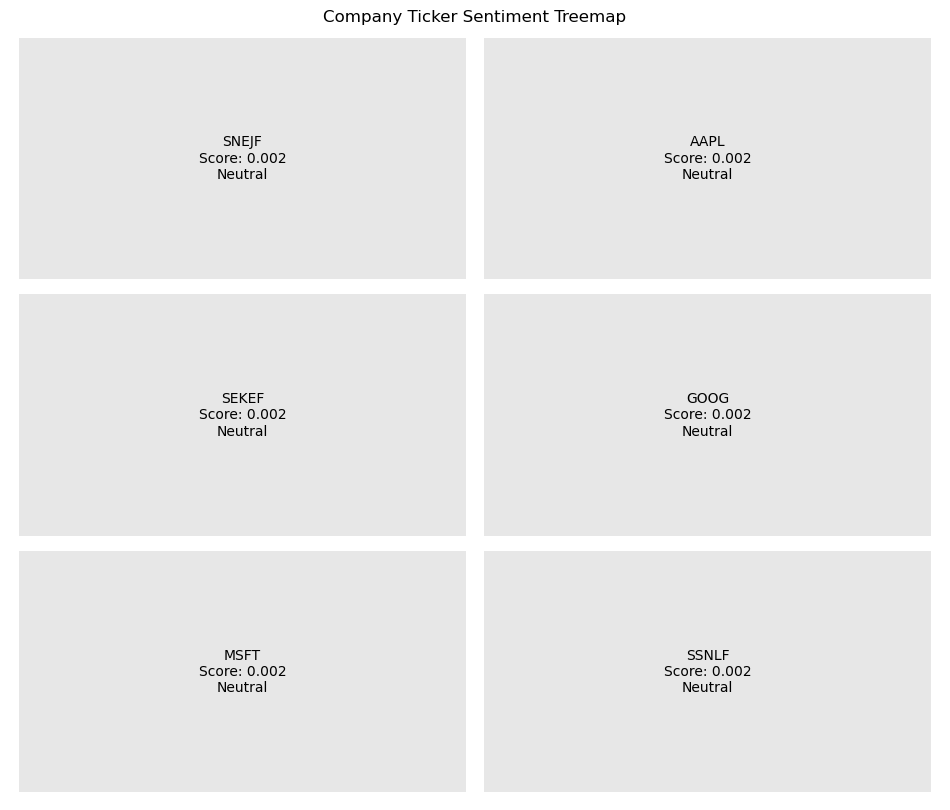

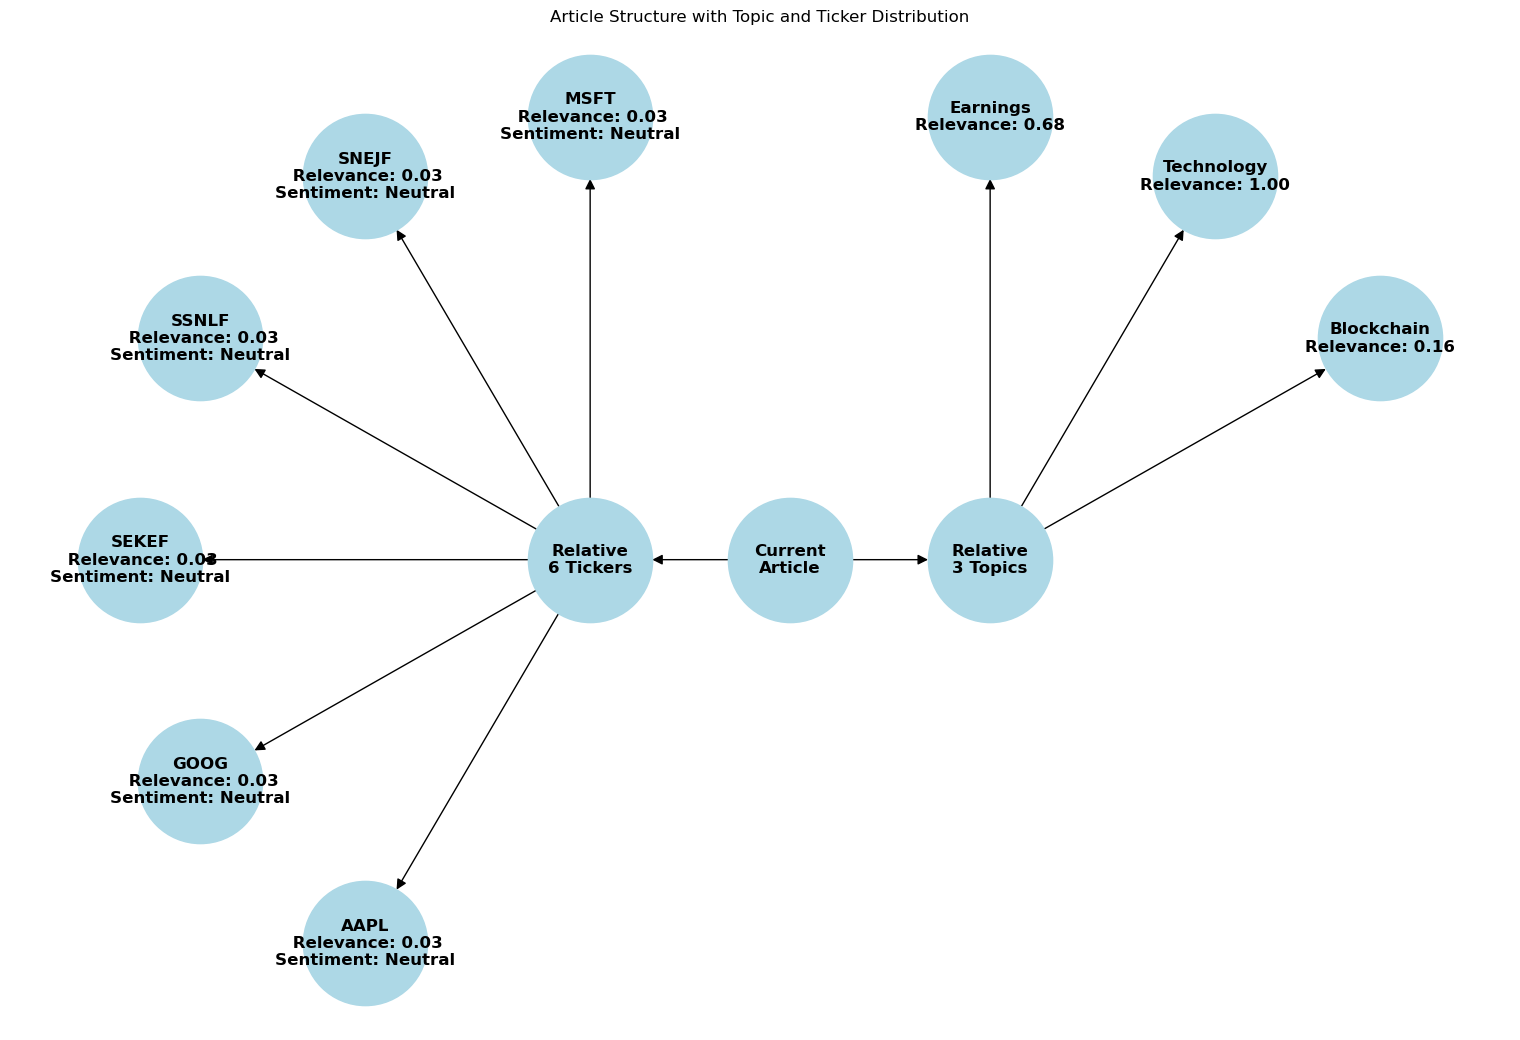

In [11]:
if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)